In [536]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pickle
# 定义状态转移模型和测量模型

def transition_model(x, u, n, alpha=0.5, beta=20, gamma=8):
    # 返回的应该是一个标量
    return alpha * x + beta * x / (1 + x**2) + gamma * np.cos(2 * (n - 1)) + u

def measurement_model(x, v):
    return x**2 / 20 + v

# 定义核特征空间的映射函数

def cal_kernel_mat(data1, data2, sigma) -> np.ndarray:
    dists = cdist(data1, data2, 'sqeuclidean')
    dists = dists / sigma
    return np.exp(-dists)


In [537]:
def generate_true_states(init_mean, N, u_n, alpha=0.5, beta=20, gamma=8):
    true_states = np.zeros(N)
    true_states[0] = init_mean
    for n in range(1, N):
        u_n_1 = np.random.normal(0, (0))
        true_states[n] = transition_model(true_states[n-1], u_n_1, n, alpha, beta, gamma)
    return true_states
# print(true_states)


def particle_filter(P_init, M, N, u_n, v_n, alpha=0.5, beta=20, gamma=8):
    particles = np.random.normal(P_init['mean'][0], (P_init['cov'][0, 0]), M)
    weights = np.ones(M) / M
    estimates = []
#     MM = 2000
    for n in range(N):
        # u_n = np.random.normal(0, (sigma_u), M)
        particles = transition_model(particles, u_n, n, alpha, beta, gamma)
        
        # v_n = np.random.normal(0, (sigma_v), M)
        y_n = measurement_model(particles, v_n)

        true_measurement = measurement_model(true_states[n], 0)
        likelihoods = np.exp(-0.5 * ((y_n - true_measurement)**2) / sigma_v)
        
        weights *= likelihoods
        weights /= np.sum(weights)
#         print("weights:", particles)
        
        resample_indices = np.random.choice(np.arange(M), size=M, p=weights)
        particles = particles[resample_indices]
        weights = weights[resample_indices]
        weights /= np.sum(weights)
        
        estimate = np.average(particles, weights=weights)
        estimates.append(estimate)
#         estimates.append(np.mean(particles * weights))
        # 所以问题在与  particles 还是 particles * weights
    
    return estimates


In [538]:
# 自适应核卡尔曼滤波器 Gausion kernel 
def adaptive_kernel_kalman_filter(P_init, M, N, u_n, v_n, sigma_v, alpha=0.5, beta=20, gamma=8, k=1e-4, lambda_reg=1e-4):
    x = np.random.multivariate_normal(P_init['mean'], P_init['cov'], M)
    x_tilde_n = x
    sigma1 = np.median(cdist(x, x) ** 2) * 2
    w0 = np.ones(M) / M
    S_n = np.eye(M) * sigma_u
    Γ0 = np.eye(M)  #(20, 20)
    V_n = np.eye(S_n.shape[0]) * sigma_v
    estimates = []

    for n in range(0, N):
        
        # Prediction in data space
        # u_n = np.random.normal(0, (sigma_u), M)
        x_n = np.array([transition_model(x_tilde_n[i], u_n[i], n, alpha, beta, gamma) for i in range(M)])
        # Prediction in kernel feature space
        sigma1 = np.median(cdist(x_n, x_n) ** 2) * 2
        w_n_minus = w0       
        S_n_minus = S_n + V_n #np.eye(S_n.shape[0]) * sigma_v
        
        # Update in data space
        # v_n = np.random.normal(0, (sigma_v), M) # 
        y_n = np.array([measurement_model(x_n[i], v_n[i]) for i in range(M)])
        y_n_measurement = measurement_model(true_states[n], 0)

        # Update in kernel feature space
        sigma2 = np.median(cdist(y_n, y_n) ** 2) * 2
        # Υn = rbf_feature_mapping(y_n, D, sigma2)
        Gyy = cal_kernel_mat(y_n, y_n, sigma2)
        G_yn = cal_kernel_mat(y_n, y_n_measurement.reshape(1, -1), sigma2) #Υn @ φ_y_n.T
        

        # Update weights w_n
        Qn = S_n_minus @ np.linalg.inv(Gyy @ S_n_minus + k * np.eye(Gyy.shape[0]))
        w_n = w_n_minus + Qn @ (G_yn.flatten() - Gyy @ w_n_minus)
        S_n = S_n_minus - Qn @ Gyy @ S_n_minus
        
        μ_xn = x_n.T @ w_n
        mean_xn = μ_xn[0].reshape(1,)
        
        # Ensure cov is a (1, 1) matrix
        cov = np.array([[np.var(x_n - μ_xn)]])
        
        x_tilde_n = np.random.multivariate_normal(mean_xn, cov, M).ravel()
        if  x_tilde_n.ndim == 1:
             x_tilde_n =  x_tilde_n[:, np.newaxis]

        sigma3 = np.median(cdist(x_tilde_n, x_tilde_n) ** 2) * 2
        GX_tilde = cal_kernel_mat(x_tilde_n, x_tilde_n, sigma3)
        V_n_1 = (np.linalg.inv(GX_tilde +  lambda_reg * np.eye(M))@ GX_tilde - np.eye(M))
        V_n = (1/M) * (V_n_1 @ V_n_1.T)
        
        GX_tilde_2=cal_kernel_mat(x_tilde_n, x_n, sigma3)
        Γn = np.linalg.inv( GX_tilde +  lambda_reg * np.eye(M)) @ GX_tilde_2
        w0 = Γn @ w_n
        S_n = Γn @ S_n @ Γn.T  
        aa = x_tilde_n.T @ w0
        estimates.append(x_tilde_n.T @ w0)

    return w_n, S_n, estimates

In [539]:
def adaptive_kernel_byes_filter(P_init, M, N, u_n, v_n, alpha=0.5, beta=20, gamma=8, lambda_reg=1e-4, k=1e-4, reg2=1e-4):
    x = np.random.normal(P_init['mean'][0], (P_init['cov'][0, 0]), M)
    x_tilde_n = x
    w0 = np.ones(M) / M

    estimates = []
    for n in range(0, N):
        # Prediction in data space
        # u_n = np.random.normal(0, (sigma_u), M)
        x_n = np.array([transition_model(x_tilde_n[i], u_n[i], n) for i in range(M)])
        if x_n.ndim == 1:
            x_n = x_n[:, np.newaxis]
        
        # Kernel matrix
        sigma1 = np.median(cdist(x_n, x_n) ** 2) * 2
        GX = cal_kernel_mat(x_n, x_n, sigma1)
        w_n_minus = w0.reshape(M)
        # Update in data space
        # v_n = np.random.normal(0, (sigma_v), M)
        y_n = np.array([measurement_model(x_n[i], v_n[i]) for i in range(M)])
        if y_n.ndim == 1:
            y_n = y_n[:, np.newaxis]
        
        y_n_measurement = measurement_model(true_states[n], 0)
        sigma2 = np.median(cdist(y_n, y_n) ** 2) * 2
        GY = cal_kernel_mat(y_n, y_n, sigma2)
        # φ_y_n = phi_y(y_n_measurement).reshape(-1, 1)
        G_yn = cal_kernel_mat(y_n, y_n_measurement.reshape(1, -1), sigma2)
        
        # Update weights w_n using Kernel Bayes Rule
        K = GX + k * np.eye(M) 
        aa = w_n_minus @ GX
        # aa = aa.reshape(M)
        gamma1 = np.linalg.solve(K, aa)
        gamma = gamma1 
        D = np.diag(np.maximum(0.0, gamma))
        
        w_n = np.linalg.solve(D @ GY +  reg2 * np.eye(M), D @ G_yn)
        μ_xn = x_n.T @ w_n
        mean_xn = μ_xn[0].reshape(1,)
        
        # Ensure cov is a (1, 1) matrix
        cov = np.array([[np.var(x_n - μ_xn)]])
        
        x_tilde_n = np.random.multivariate_normal(mean_xn, cov, M).ravel()
        if  x_tilde_n.ndim == 1:
             x_tilde_n =  x_tilde_n[:, np.newaxis]
                
        sigma3 = np.median(cdist(x_tilde_n, x_tilde_n) ** 2) * 2
        sigma4 = np.median(cdist(x_tilde_n, x_n) ** 2) * 2
        GX_tilde = cal_kernel_mat(x_tilde_n, x_tilde_n, sigma3)
        GX_tilde_2=cal_kernel_mat(x_tilde_n, x_n, sigma3)
        Γn = np.linalg.inv(GX_tilde + lambda_reg * np.eye(M)) @ GX_tilde_2
        estimates.append(x_tilde_n.T @ w0)
        
        # akbf_estimates_flat = np.array([estimate.squeeze() for estimate in akbf_estimates])
    
    return w_n, estimates


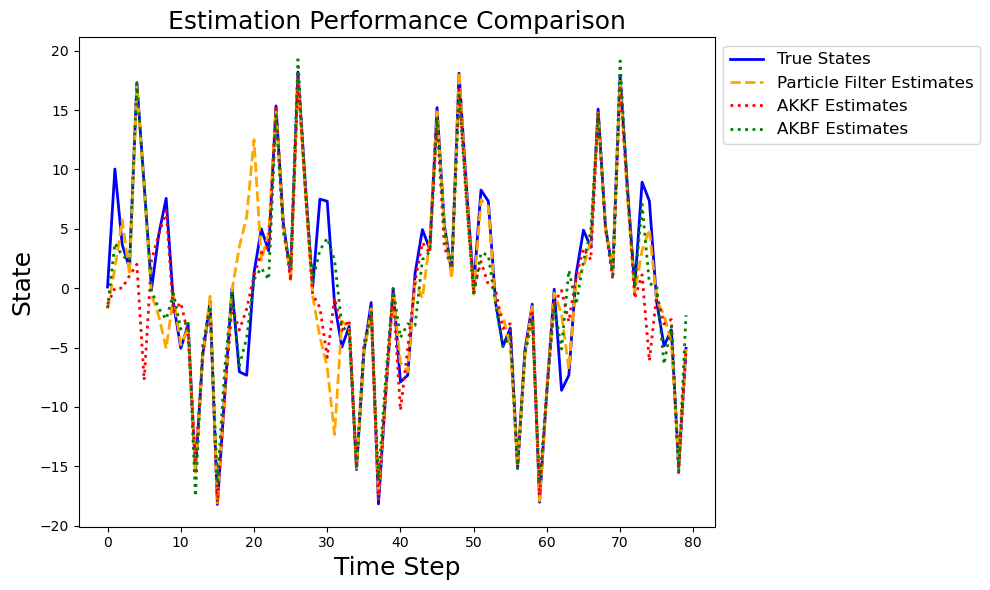

In [310]:
# 只画出状态

# 定义参数
P_init = {
    'mean': [0.1],
    'cov': np.eye(1) * 0
}
M = 30
N = 80
sigma_u = 1  
sigma_v = 1
u_n = np.random.normal(0, np.sqrt(sigma_u), M)
v_n = np.random.normal(0, np.sqrt(sigma_v), M)

# sigma1 = np.median(cdist(n_x, n_x) ** 2) * 2
# sigma2 = np.median(cdist(n_Y, train_Y) ** 2) * 2
# 生成真实状态 
true_states = generate_true_states(P_init['mean'][0], N, sigma_u)

# 运行三个滤波器
pf_estimates = particle_filter(P_init, M, N, u_n, v_n)
# gpf_estimates = gaussian_particle_filter(P_init, M, N, u_n, v_n)
_, _, akkf_estimates = adaptive_kernel_kalman_filter(P_init, M, N, u_n, v_n,  sigma_v)
akkf_estimates_flat = np.array([estimate.squeeze() for estimate in akkf_estimates])
_,  akbf_estimates = adaptive_kernel_byes_filter(P_init, M, N, u_n, v_n)
akbf_estimates_flat = np.array([estimate.squeeze() for estimate in akbf_estimates])


# 调整 figure 大小
fig = plt.figure(figsize=(10, 6))
# plt.figure(figsize=(10, 6))  # 将图表宽度设为10，高度设为6

plt.plot(true_states, label='True States', linestyle='-', color='blue', linewidth=2)
plt.plot(pf_estimates, label='Particle Filter Estimates', linestyle='--', color='orange', linewidth=2)
# plt.plot(gpf_estimates, label='Gaussian Particle Filter Estimates', linestyle='-.', color='green')
plt.plot(akkf_estimates_flat, label='AKKF Estimates', linestyle=':', color='red', linewidth=2)
plt.plot(akbf_estimates_flat, label='AKBF Estimates', linestyle=':', color='green', linewidth=2)

plt.xlabel('Time Step', fontsize=18)
plt.ylabel('State', fontsize=18)

# 调整 legend 的大小
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 12})  # 这里prop={'size': 10} 控制 legend 的字体大小

plt.title('Estimation Performance Comparison', fontsize=18)
plt.tight_layout()  # 自动调整布局

with open('G-non-linear-state-sigma5.pkl', 'wb') as f:
    pickle.dump(fig, f)


plt.show()

In [311]:
# #.计算 关于参数lambda 的 关系


# import numpy as np
# import matplotlib.pyplot as plt

# # 假设你已经定义了 transition_model, measurement_model, cal_kernel_mat 等函数
# P_init = {
#     'mean': [0.1],
#     'cov': np.eye(1) * 1
# }
# # P_init = {'mean': np.array([0]), 'cov': np.array([[1]])}  # 初始化 P_init
# M = 100  # 粒子数
# N = 50   # 时间步数
# sigma_u = 3  # 预测噪声方差
# sigma_v = 3  # 观测噪声方差
# lambda_values = [5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5]  # 不同的 lambda_reg 值

# true_states = generate_true_states(P_init['mean'][0], N, sigma_u)

# all_estimates = []

# for lambda_reg in lambda_values:
#     _ , akbf_estimates = adaptive_kernel_byes_filter(P_init, M, N, sigma_u, sigma_v, 
#                                                  lambda_reg=lambda_reg, k=lambda_reg, reg2=lambda_reg)
#     akbf_estimates_flat = np.array([estimate.squeeze() for estimate in akbf_estimates])
#     mse = np.mean((akbf_estimates_flat - true_states)**2)
#     all_estimates.append(mse)



# plt.figure(figsize=(10, 6))
# plt.plot(lambda_values, all_estimates, marker='o', linestyle='-', color='blue')
# plt.xscale('log')  # 使用对数刻度显示 lambda_reg
# plt.title('MSE vs Regularization Parameter λ', fontsize=14)
# plt.xlabel('Regularization Parameter λ (log scale)', fontsize=14)
# plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
# plt.grid(True)
# plt.show()  



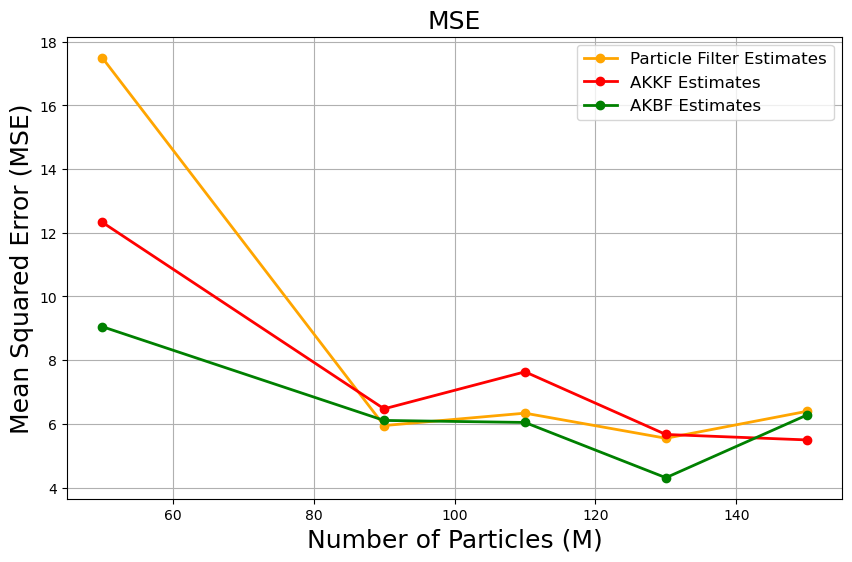

In [567]:
# 计算 关于不同的 粒子数的关系

import numpy as np
import matplotlib.pyplot as plt

# 定义参数
P_init = {
    'mean': [0.1],
    'cov': np.eye(1) * 0
}
N = 80
sigma_u = 1
sigma_v = 1

# 定义粒子数量列表
M_values = [50, 90, 110, 130, 150]

# 生成真实状态
true_states = generate_true_states(P_init['mean'][0], N, sigma_u)

# 存储每个M对应的均方误差
pf_mse_list = []
akbf_mse_list = []
akkf_mse_list = []

# 运行滤波器并计算MSE
for M in M_values:
    u_n = np.random.normal(0, (sigma_u), M)
    v_n = np.random.normal(0, (sigma_v), M)
    pf_estimates = particle_filter(P_init, M, N, u_n, v_n)
    mse = np.mean((pf_estimates - true_states)**2)
    pf_mse_list.append(mse)
    
    _, _, akkf_estimates = adaptive_kernel_kalman_filter(P_init, M, N, u_n, v_n, sigma_v)
    akkf_estimates_flat = np.array([estimate.squeeze() for estimate in akkf_estimates])
    mse = np.mean((akkf_estimates_flat - true_states)**2)
    akkf_mse_list.append(mse)
    
    _, akbf_estimates = adaptive_kernel_byes_filter(P_init, M, N, u_n, v_n)
    akbf_estimates_flat = np.array([estimate.squeeze() for estimate in akbf_estimates])
    mse = np.mean((akbf_estimates_flat - true_states)**2)
    akbf_mse_list.append(mse)

# 绘制MSE vs 粒子数量的图像
fig = plt.figure(figsize=(10, 6))
plt.plot(M_values, pf_mse_list, label='Particle Filter Estimates', marker='o', linestyle='-', color='orange', linewidth=2)
plt.plot(M_values, akkf_mse_list, label='AKKF Estimates', marker='o', linestyle='-', color='red', linewidth=2)
plt.plot(M_values, akbf_mse_list, label='AKBF Estimates', marker='o', linestyle='-', color='green', linewidth=2)
plt.title('MSE', fontsize=18)
plt.xlabel('Number of Particles (M)', fontsize=18)
plt.ylabel('Mean Squared Error (MSE)', fontsize=18)
plt.grid(True)
plt.legend(loc='upper right', fontsize=12)
plt.show()

with open('G-non-linear-state-sigma1.pkl', 'wb') as f:
    pickle.dump(fig, f)


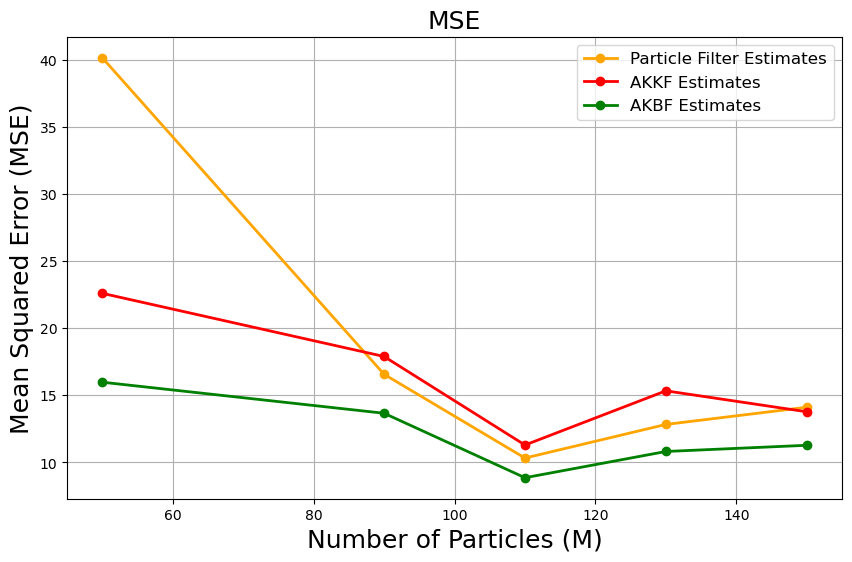

In [374]:
# 计算 关于不同的 粒子数的关系

import numpy as np
import matplotlib.pyplot as plt

# 定义参数
P_init = {
    'mean': [0.1],
    'cov': np.eye(1) * 0
}
N = 80
sigma_u = 4
sigma_v = 4

# 定义粒子数量列表
M_values = [50, 90, 110, 130, 150]

# 生成真实状态
true_states = generate_true_states(P_init['mean'][0], N, sigma_u)

# 存储每个M对应的均方误差
pf_mse_list = []
akbf_mse_list = []
akkf_mse_list = []

# 运行滤波器并计算MSE
for M in M_values:
    u_n = np.random.normal(0, (sigma_u), M)
    v_n = np.random.normal(0, (sigma_v), M)
    pf_estimates = particle_filter(P_init, M, N, u_n, v_n)
    mse = np.mean((pf_estimates - true_states)**2)
    pf_mse_list.append(mse)
    
    _, _, akkf_estimates = adaptive_kernel_kalman_filter(P_init, M, N, u_n, v_n, sigma_v)
    akkf_estimates_flat = np.array([estimate.squeeze() for estimate in akkf_estimates])
    mse = np.mean((akkf_estimates_flat - true_states)**2)
    akkf_mse_list.append(mse)
    
    _, akbf_estimates = adaptive_kernel_byes_filter(P_init, M, N, u_n, v_n)
    akbf_estimates_flat = np.array([estimate.squeeze() for estimate in akbf_estimates])
    mse = np.mean((akbf_estimates_flat - true_states)**2)
    akbf_mse_list.append(mse)

# 绘制MSE vs 粒子数量的图像
fig = plt.figure(figsize=(10, 6))
plt.plot(M_values, pf_mse_list, label='Particle Filter Estimates', marker='o', linestyle='-', color='orange', linewidth=2)
plt.plot(M_values, akkf_mse_list, label='AKKF Estimates', marker='o', linestyle='-', color='red', linewidth=2)
plt.plot(M_values, akbf_mse_list, label='AKBF Estimates', marker='o', linestyle='-', color='green', linewidth=2)
plt.title('MSE', fontsize=18)
plt.xlabel('Number of Particles (M)', fontsize=18)
plt.ylabel('Mean Squared Error (MSE)', fontsize=18)
plt.grid(True)
plt.legend(loc='upper right', fontsize=12)
plt.show()

with open('G-non-linear-state-sigma5.pkl', 'wb') as f:
    pickle.dump(fig, f)